<a href="https://colab.research.google.com/github/Steffenanderson/NFL-Predictions/blob/main/NFL_Predictions_Model_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2 - Part 4 (Model Tuning)

### Import Libraries and Mount Data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics
import warnings 
warnings.filterwarnings('ignore')

import xgboost
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

offense = pd.read_excel('/content/drive/MyDrive/NFL Predictions/NFL_historical_statistics_offense.xlsx')
defense = pd.read_excel('/content/drive/MyDrive/NFL Predictions/NFL_historical_statistics_defense.xlsx')
sb_winner = pd.read_excel('/content/drive/MyDrive/NFL Predictions/NFL_historical_statistics_superbowl.xlsx')

In [2]:
# offense data
offense.head()

,Rk,Tm,G,PF_Total,Yds_Total,Ply_Total,Y/P_Total,TO_Total,FL_Total,1stD_Total,Cmp_Passing,Att_Passing,Yds_Passing,TD_Passing,Int_Passing,NY/A_Passing,1stD_Passing,Att_Rushing,Yds_Rushing,TD_Rushing,Y/A_Rushing,1stD_Rushing,Pen_Penalties,Yds_Penalties,1stPy_Penalties,Sc%,TO%,EXP,Year,Off_Def
0,1,Green Bay Packers,16,509,6224,990,6.3,11,6,358,372,526,4106,48,5,7.5,216,443,2118,16,4.8,114,84,684,28,49.7,5.6,290.75,2020,Offense
1,2,Buffalo Bills,16,501,6343,1034,6.1,22,11,397,410,596,4620,40,11,7.4,240,411,1723,16,4.2,119,102,941,38,49.4,11.8,228.66,2020,Offense
2,3,Tampa Bay Buccaneers,16,492,6145,1017,6.0,17,5,364,410,626,4626,42,12,7.1,238,369,1519,16,4.1,82,84,715,44,47.8,8.9,246.24,2020,Offense
3,4,Tennessee Titans,16,491,6343,1031,6.2,12,5,381,316,485,3653,33,7,7.2,203,521,2690,26,5.2,142,86,783,36,47.9,7.2,245.01,2020,Offense
4,5,New Orleans Saints,16,482,6023,1045,5.8,17,9,367,370,522,3758,28,8,6.8,199,494,2265,30,4.6,147,98,1005,21,45.5,9.0,176.94,2020,Offense


In [3]:
# defense data
defense.head()

,Rk,Tm,G,PF_Total,Yds_Total,Ply_Total,Y/P_Total,TO_Total,FL_Total,1stD_Total,Cmp_Passing,Att_Passing,Yds_Passing,TD_Passing,Int_Passing,NY/A_Passing,1stD_Passing,Att_Rushing,Yds_Rushing,TD_Rushing,Y/A_Rushing,1stD_Rushing,Pen_Penalties,Yds_Penalties,1stPy_Penalties,Sc%,TO%,EXP,Year,Off_Def
0,1,Los Angeles Rams,16,296,4511,989,4.6,22,8,280,347,548,3051,17,14,5.1,170,388,1460,12,3.8,91,78,582,19,27.9,12.0,85.89,2020,Defense
1,2,Baltimore Ravens,16,303,5276,1017,5.2,22,12,347,380,596,3536,22,10,5.6,213,382,1740,12,4.6,96,77,646,38,30.0,12.4,-17.69,2020,Defense
2,3,Pittsburgh Steelers,16,312,4893,996,4.9,27,9,281,298,526,3110,22,18,5.3,163,414,1783,13,4.3,94,103,980,24,29.3,13.8,33.24,2020,Defense
3,4,Washington Football Team,16,329,4873,1004,4.9,23,7,289,330,529,3068,21,16,5.3,161,428,1805,14,4.2,100,85,708,28,31.4,12.2,32.51,2020,Defense
4,5,New Orleans Saints,16,337,4974,992,5.0,26,8,320,333,557,3472,28,18,5.8,185,390,1502,11,3.9,85,64,517,50,34.7,13.1,-40.02,2020,Defense


In [4]:
# superbowl stats
sb_winner.head()

,Date,SB,Winner,Pts,Loser,Pts.1,MVP,Stadium,City,State
0,Feb 7 2021,55,Tampa Bay Buccaneers,31,Kansas City Chiefs,9,Tom Brady,Raymond James Stadium,Tampa,Florida
1,Feb 2 2020,54,Kansas City Chiefs,31,San Francisco 49ers,20,Patrick Mahomes,Hard Rock Stadium,Miami Gardens,Florida
2,Feb 3 2019,53,New England Patriots,13,Los Angeles Rams,3,Julian Edelman,Mercedes-Benz Stadium,Atlanta,Georgia
3,Feb 4 2018,52,Philadelphia Eagles,41,New England Patriots,33,Nick Foles,U.S. Bank Stadium,Minneapolis,Minnesota
4,Feb 5 2017,51,New England Patriots,34,Atlanta Falcons,28,Tom Brady,NRG Stadium,Houston,Texas


### Exploratory Data Analaysis (EDA)

In [5]:
# change column names
offense.drop(columns='Off_Def',inplace=True)
offense.columns = ['O_Rank', 'Team', 'O_Games_Played', 'O_Points_For', 'O_Total_Yards',
       'O_Plays', 'O_Y/Play', 'O_TO', 'O_Fumbles_Lost',
       'O_1st_D', 'O_P_Completions', 'O_P_Attempts', 'O_P_Yards', 'O_P_TD',
       'O_P_Int', 'O_P_Y/PA', 'O_P_Passing_1st_D', 'O_R_Att', 'O_R_Yards',
       'O_R_TD', 'O_R_Y/A', 'O_R_1st_D', 'O_Pe', 'O_Pe_Yards',
       'O_Pe_1st_D', 'O_Scoring_Drives', 'O_TO_%', 'O_Expected_Points', 'Year']

offense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   O_Rank             352 non-null    int64  
 1   Team               352 non-null    object 
 2   O_Games_Played     352 non-null    int64  
 3   O_Points_For       352 non-null    int64  
 4   O_Total_Yards      352 non-null    int64  
 5   O_Plays            352 non-null    int64  
 6   O_Y/Play           352 non-null    float64
 7   O_TO               352 non-null    int64  
 8   O_Fumbles_Lost     352 non-null    int64  
 9   O_1st_D            352 non-null    int64  
 10  O_P_Completions    352 non-null    int64  
 11  O_P_Attempts       352 non-null    int64  
 12  O_P_Yards          352 non-null    int64  
 13  O_P_TD             352 non-null    int64  
 14  O_P_Int            352 non-null    int64  
 15  O_P_Y/PA           352 non-null    float64
 16  O_P_Passing_1st_D  352 non

In [6]:
# change column names
defense.drop(columns='Off_Def',inplace=True)
defense.columns = ['D_Rank', 'Team', 'D_Games_Played', 'D_Points_Allowed', 'D_Total_Yards',
       'D_Plays', 'D_Y/Play', 'D_TD', 'D_Fumbles_Lost',
       'D_1st_D', 'D_P_Completions', 'D_P_Attempts', 'D_P_Yards', 'D_P_TD',
       'D_P_Int', 'D_P_Y/PA', 'D_P_Passing_1st_D', 'D_R_Att', 'D_R_Yards',
       'D_R_TD', 'D_R_Y/A', 'D_R_1st_D', 'D_Pe', 'D_Pe_Yards',
       'D_Pe_1st_D', 'D_Scoring_Drives', 'D_TD_%', 'D_Expected_Points', 'Year']

defense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   D_Rank             352 non-null    int64  
 1   Team               352 non-null    object 
 2   D_Games_Played     352 non-null    int64  
 3   D_Points_Allowed   352 non-null    int64  
 4   D_Total_Yards      352 non-null    int64  
 5   D_Plays            352 non-null    int64  
 6   D_Y/Play           352 non-null    float64
 7   D_TD               352 non-null    int64  
 8   D_Fumbles_Lost     352 non-null    int64  
 9   D_1st_D            352 non-null    int64  
 10  D_P_Completions    352 non-null    int64  
 11  D_P_Attempts       352 non-null    int64  
 12  D_P_Yards          352 non-null    int64  
 13  D_P_TD             352 non-null    int64  
 14  D_P_Int            352 non-null    int64  
 15  D_P_Y/PA           352 non-null    float64
 16  D_P_Passing_1st_D  352 non

In [7]:
# merge offense and defense data
off_def = offense.merge(defense)
off_def.head()

,O_Rank,Team,O_Games_Played,O_Points_For,O_Total_Yards,O_Plays,O_Y/Play,O_TO,O_Fumbles_Lost,O_1st_D,O_P_Completions,O_P_Attempts,O_P_Yards,O_P_TD,O_P_Int,O_P_Y/PA,O_P_Passing_1st_D,O_R_Att,O_R_Yards,O_R_TD,O_R_Y/A,O_R_1st_D,O_Pe,O_Pe_Yards,O_Pe_1st_D,O_Scoring_Drives,O_TO_%,O_Expected_Points,Year,D_Rank,D_Games_Played,D_Points_Allowed,D_Total_Yards,D_Plays,D_Y/Play,D_TD,D_Fumbles_Lost,D_1st_D,D_P_Completions,D_P_Attempts,D_P_Yards,D_P_TD,D_P_Int,D_P_Y/PA,D_P_Passing_1st_D,D_R_Att,D_R_Yards,D_R_TD,D_R_Y/A,D_R_1st_D,D_Pe,D_Pe_Yards,D_Pe_1st_D,D_Scoring_Drives,D_TD_%,D_Expected_Points
0,1,Green Bay Packers,16,509,6224,990,6.3,11,6,358,372,526,4106,48,5,7.5,216,443,2118,16,4.8,114,84,684,28,49.7,5.6,290.75,2020,13,16,369,5344,974,5.5,18,7,332,346,536,3539,23,11,6.1,184,397,1805,16,4.5,119,79,734,29,39.9,11.4,-109.67
1,2,Buffalo Bills,16,501,6343,1034,6.1,22,11,397,410,596,4620,40,11,7.4,240,411,1723,16,4.2,119,102,941,38,49.4,11.8,228.66,2020,16,16,375,5640,1025,5.5,26,11,351,369,573,3726,23,15,6.1,199,414,1914,21,4.6,125,86,728,27,39.4,15.3,-123.10
2,3,Tampa Bay Buccaneers,16,492,6145,1017,6.0,17,5,364,410,626,4626,42,12,7.1,238,369,1519,16,4.1,82,84,715,44,47.8,8.9,246.24,2020,8,16,355,5234,1023,5.1,25,10,319,426,617,3945,29,15,5.9,215,358,1289,10,3.6,78,95,1015,26,33.7,14.0,-22.04
3,4,Tennessee Titans,16,491,6343,1031,6.2,12,5,381,316,485,3653,33,7,7.2,203,521,2690,26,5.2,142,86,783,36,47.9,7.2,245.01,2020,24,16,439,6372,1076,5.9,23,8,391,423,630,4439,36,15,6.8,247,427,1933,18,4.5,113,103,840,31,45.2,13.3,-185.20
4,5,New Orleans Saints,16,482,6023,1045,5.8,17,9,367,370,522,3758,28,8,6.8,199,494,2265,30,4.6,147,98,1005,21,45.5,9.0,176.94,2020,5,16,337,4974,992,5.0,26,8,320,333,557,3472,28,18,5.8,185,390,1502,11,3.9,85,64,517,50,34.7,13.1,-40.02


In [8]:
sb_winner.head()

,Date,SB,Winner,Pts,Loser,Pts.1,MVP,Stadium,City,State
0,Feb 7 2021,55,Tampa Bay Buccaneers,31,Kansas City Chiefs,9,Tom Brady,Raymond James Stadium,Tampa,Florida
1,Feb 2 2020,54,Kansas City Chiefs,31,San Francisco 49ers,20,Patrick Mahomes,Hard Rock Stadium,Miami Gardens,Florida
2,Feb 3 2019,53,New England Patriots,13,Los Angeles Rams,3,Julian Edelman,Mercedes-Benz Stadium,Atlanta,Georgia
3,Feb 4 2018,52,Philadelphia Eagles,41,New England Patriots,33,Nick Foles,U.S. Bank Stadium,Minneapolis,Minnesota
4,Feb 5 2017,51,New England Patriots,34,Atlanta Falcons,28,Tom Brady,NRG Stadium,Houston,Texas


In [9]:
# format date to year 
sb_winner.Date = pd.to_datetime(sb_winner.Date)
sb_winner['Year'] = pd.DatetimeIndex(sb_winner['Date']).year
# new DataFrame with year and winner
sb_winner = sb_winner[['Year', 'Winner']]
# minus 1 year - 2021 calendar year SB is for 2020 season
sb_winner['Year'] = sb_winner['Year'] - 1
# add Superbowl column with 1 
sb_winner['Superbowl Winner'] = 1

sb_winner.head()

,Year,Winner,Superbowl Winner
0,2020,Tampa Bay Buccaneers,1
1,2019,Kansas City Chiefs,1
2,2018,New England Patriots,1
3,2017,Philadelphia Eagles,1
4,2016,New England Patriots,1


In [10]:
# merge superbowl winner to off_def df
data = pd.merge(off_def, sb_winner, left_on = ['Year', 'Team'], right_on = ['Year', 'Winner'], how = 'left' )

data['Superbowl Winner'].value_counts()

data['Superbowl Winner'].replace(to_replace=np.NaN, value=0, inplace=True)
data.drop(columns='Winner', inplace=True)

data['Superbowl Winner'].value_counts()
data.head()

,O_Rank,Team,O_Games_Played,O_Points_For,O_Total_Yards,O_Plays,O_Y/Play,O_TO,O_Fumbles_Lost,O_1st_D,O_P_Completions,O_P_Attempts,O_P_Yards,O_P_TD,O_P_Int,O_P_Y/PA,O_P_Passing_1st_D,O_R_Att,O_R_Yards,O_R_TD,O_R_Y/A,O_R_1st_D,O_Pe,O_Pe_Yards,O_Pe_1st_D,O_Scoring_Drives,O_TO_%,O_Expected_Points,Year,D_Rank,D_Games_Played,D_Points_Allowed,D_Total_Yards,D_Plays,D_Y/Play,D_TD,D_Fumbles_Lost,D_1st_D,D_P_Completions,D_P_Attempts,D_P_Yards,D_P_TD,D_P_Int,D_P_Y/PA,D_P_Passing_1st_D,D_R_Att,D_R_Yards,D_R_TD,D_R_Y/A,D_R_1st_D,D_Pe,D_Pe_Yards,D_Pe_1st_D,D_Scoring_Drives,D_TD_%,D_Expected_Points,Superbowl Winner
0,1,Green Bay Packers,16,509,6224,990,6.3,11,6,358,372,526,4106,48,5,7.5,216,443,2118,16,4.8,114,84,684,28,49.7,5.6,290.75,2020,13,16,369,5344,974,5.5,18,7,332,346,536,3539,23,11,6.1,184,397,1805,16,4.5,119,79,734,29,39.9,11.4,-109.67,0.0
1,2,Buffalo Bills,16,501,6343,1034,6.1,22,11,397,410,596,4620,40,11,7.4,240,411,1723,16,4.2,119,102,941,38,49.4,11.8,228.66,2020,16,16,375,5640,1025,5.5,26,11,351,369,573,3726,23,15,6.1,199,414,1914,21,4.6,125,86,728,27,39.4,15.3,-123.10,0.0
2,3,Tampa Bay Buccaneers,16,492,6145,1017,6.0,17,5,364,410,626,4626,42,12,7.1,238,369,1519,16,4.1,82,84,715,44,47.8,8.9,246.24,2020,8,16,355,5234,1023,5.1,25,10,319,426,617,3945,29,15,5.9,215,358,1289,10,3.6,78,95,1015,26,33.7,14.0,-22.04,1.0
3,4,Tennessee Titans,16,491,6343,1031,6.2,12,5,381,316,485,3653,33,7,7.2,203,521,2690,26,5.2,142,86,783,36,47.9,7.2,245.01,2020,24,16,439,6372,1076,5.9,23,8,391,423,630,4439,36,15,6.8,247,427,1933,18,4.5,113,103,840,31,45.2,13.3,-185.20,0.0
4,5,New Orleans Saints,16,482,6023,1045,5.8,17,9,367,370,522,3758,28,8,6.8,199,494,2265,30,4.6,147,98,1005,21,45.5,9.0,176.94,2020,5,16,337,4974,992,5.0,26,8,320,333,557,3472,28,18,5.8,185,390,1502,11,3.9,85,64,517,50,34.7,13.1,-40.02,0.0


In [11]:
sb_winner['Superbowl Winner'].value_counts()

1    55
Name: Superbowl Winner, dtype: int64

In [12]:
combine_file = pd.DataFrame(data)
combine_file.head()

,O_Rank,Team,O_Games_Played,O_Points_For,O_Total_Yards,O_Plays,O_Y/Play,O_TO,O_Fumbles_Lost,O_1st_D,O_P_Completions,O_P_Attempts,O_P_Yards,O_P_TD,O_P_Int,O_P_Y/PA,O_P_Passing_1st_D,O_R_Att,O_R_Yards,O_R_TD,O_R_Y/A,O_R_1st_D,O_Pe,O_Pe_Yards,O_Pe_1st_D,O_Scoring_Drives,O_TO_%,O_Expected_Points,Year,D_Rank,D_Games_Played,D_Points_Allowed,D_Total_Yards,D_Plays,D_Y/Play,D_TD,D_Fumbles_Lost,D_1st_D,D_P_Completions,D_P_Attempts,D_P_Yards,D_P_TD,D_P_Int,D_P_Y/PA,D_P_Passing_1st_D,D_R_Att,D_R_Yards,D_R_TD,D_R_Y/A,D_R_1st_D,D_Pe,D_Pe_Yards,D_Pe_1st_D,D_Scoring_Drives,D_TD_%,D_Expected_Points,Superbowl Winner
0,1,Green Bay Packers,16,509,6224,990,6.3,11,6,358,372,526,4106,48,5,7.5,216,443,2118,16,4.8,114,84,684,28,49.7,5.6,290.75,2020,13,16,369,5344,974,5.5,18,7,332,346,536,3539,23,11,6.1,184,397,1805,16,4.5,119,79,734,29,39.9,11.4,-109.67,0.0
1,2,Buffalo Bills,16,501,6343,1034,6.1,22,11,397,410,596,4620,40,11,7.4,240,411,1723,16,4.2,119,102,941,38,49.4,11.8,228.66,2020,16,16,375,5640,1025,5.5,26,11,351,369,573,3726,23,15,6.1,199,414,1914,21,4.6,125,86,728,27,39.4,15.3,-123.10,0.0
2,3,Tampa Bay Buccaneers,16,492,6145,1017,6.0,17,5,364,410,626,4626,42,12,7.1,238,369,1519,16,4.1,82,84,715,44,47.8,8.9,246.24,2020,8,16,355,5234,1023,5.1,25,10,319,426,617,3945,29,15,5.9,215,358,1289,10,3.6,78,95,1015,26,33.7,14.0,-22.04,1.0
3,4,Tennessee Titans,16,491,6343,1031,6.2,12,5,381,316,485,3653,33,7,7.2,203,521,2690,26,5.2,142,86,783,36,47.9,7.2,245.01,2020,24,16,439,6372,1076,5.9,23,8,391,423,630,4439,36,15,6.8,247,427,1933,18,4.5,113,103,840,31,45.2,13.3,-185.20,0.0
4,5,New Orleans Saints,16,482,6023,1045,5.8,17,9,367,370,522,3758,28,8,6.8,199,494,2265,30,4.6,147,98,1005,21,45.5,9.0,176.94,2020,5,16,337,4974,992,5.0,26,8,320,333,557,3472,28,18,5.8,185,390,1502,11,3.9,85,64,517,50,34.7,13.1,-40.02,0.0


In [13]:
combine_file.to_csv('/content/drive/MyDrive/NFL Predictions/combine_file.csv', index=False)

### Update Team Names - Due to Franchise Move

      The Oakland Raiders changed the team name to the Las Vegas Raiders
      The San Diego Chargers changed the team name to the Los Angeles Chargers
      The Washington Redskins changed the team name to the Washington Football Team
      The St. Louis Rams changed the team name to the Los Angeles Rams

In [14]:
offense.Team.unique()

array(['Green Bay Packers', 'Buffalo Bills', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'New Orleans Saints', 'Kansas City Chiefs',
       'Baltimore Ravens', 'Seattle Seahawks', 'Indianapolis Colts',
       'Las Vegas Raiders', 'Minnesota Vikings', 'Pittsburgh Steelers',
       'Arizona Cardinals', 'Cleveland Browns', 'Miami Dolphins',
       'Atlanta Falcons', 'Dallas Cowboys', 'Houston Texans',
       'Los Angeles Chargers', 'Detroit Lions', 'San Francisco 49ers',
       'Los Angeles Rams', 'Chicago Bears', 'Carolina Panthers',
       'Washington Football Team', 'Philadelphia Eagles',
       'New England Patriots', 'Denver Broncos', 'Cincinnati Bengals',
       'Jacksonville Jaguars', 'New York Giants', 'New York Jets',
       'Oakland Raiders', 'Washington Redskins', 'San Diego Chargers',
       'St. Louis Rams'], dtype=object)

**Update Oakland Raiders to the Las Vegas Raiders - All datasets**

In [15]:
for index in offense.index:
    if offense.loc[index,'Team']=='Oakland Raiders':
        offense.loc[index,'Team'] = 'Las Vegas Raiders'

for index in defense.index:
    if defense.loc[index,'Team']=='Oakland Raiders':
        defense.loc[index,'Team'] = 'Las Vegas Raiders'

for index in sb_winner.index:
    if sb_winner.loc[index,'Winner']=='Oakland Raiders':
        sb_winner.loc[index,'Winner'] = 'Las Vegas Raiders'

**Update San Diego Chargers to the Los Angelos Chargers - All datasets**

In [16]:
for index in offense.index:
    if offense.loc[index,'Team']=='San Diego Chargers':
        offense.loc[index,'Team'] = 'Los Angeles Chargers'

for index in defense.index:
    if defense.loc[index,'Team']=='San Diego Chargers':
        defense.loc[index,'Team'] = 'Los Angeles Chargers'

for index in sb_winner.index:
    if sb_winner.loc[index,'Winner']=='San Diego Chargers':
        sb_winner.loc[index,'Winner'] = 'Los Angeles Chargers'

**Update Washington Redskins to the Washington Football Team - All datasets**

In [17]:
for index in offense.index:
    if offense.loc[index,'Team']=='Washington Redskins':
        offense.loc[index,'Team'] = 'Washington Football Team'

for index in defense.index:
    if defense.loc[index,'Team']=='Washington Redskins':
        defense.loc[index,'Team'] = 'Washington Football Team'

for index in sb_winner.index:
    if sb_winner.loc[index,'Winner']=='Washington Redskins':
        sb_winner.loc[index,'Winner'] = 'Washington Football Team'

**Update St. Louis Rams to the Los Angelos Rams - All datasets**

In [18]:
for index in offense.index:
    if offense.loc[index,'Team']=='St. Louis Rams':
        offense.loc[index,'Team'] = 'Los Angeles Rams'

for index in defense.index:
    if defense.loc[index,'Team']=='St. Louis Rams':
        defense.loc[index,'Team'] = 'Los Angeles Rams'

for index in sb_winner.index:
    if sb_winner.loc[index,'Winner']=='St. Louis Rams':
        sb_winner.loc[index,'Winner'] = 'Los Angeles Rams'

In [19]:
offense.Team.unique()

array(['Green Bay Packers', 'Buffalo Bills', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'New Orleans Saints', 'Kansas City Chiefs',
       'Baltimore Ravens', 'Seattle Seahawks', 'Indianapolis Colts',
       'Las Vegas Raiders', 'Minnesota Vikings', 'Pittsburgh Steelers',
       'Arizona Cardinals', 'Cleveland Browns', 'Miami Dolphins',
       'Atlanta Falcons', 'Dallas Cowboys', 'Houston Texans',
       'Los Angeles Chargers', 'Detroit Lions', 'San Francisco 49ers',
       'Los Angeles Rams', 'Chicago Bears', 'Carolina Panthers',
       'Washington Football Team', 'Philadelphia Eagles',
       'New England Patriots', 'Denver Broncos', 'Cincinnati Bengals',
       'Jacksonville Jaguars', 'New York Giants', 'New York Jets'],
      dtype=object)

## New 5 Year Dataset 

In [20]:
year_5y = data[(data['Year'] > 2015)]
year_5y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   O_Rank             160 non-null    int64  
 1   Team               160 non-null    object 
 2   O_Games_Played     160 non-null    int64  
 3   O_Points_For       160 non-null    int64  
 4   O_Total_Yards      160 non-null    int64  
 5   O_Plays            160 non-null    int64  
 6   O_Y/Play           160 non-null    float64
 7   O_TO               160 non-null    int64  
 8   O_Fumbles_Lost     160 non-null    int64  
 9   O_1st_D            160 non-null    int64  
 10  O_P_Completions    160 non-null    int64  
 11  O_P_Attempts       160 non-null    int64  
 12  O_P_Yards          160 non-null    int64  
 13  O_P_TD             160 non-null    int64  
 14  O_P_Int            160 non-null    int64  
 15  O_P_Y/PA           160 non-null    float64
 16  O_P_Passing_1st_D  160 non

In [21]:
# sns.pairplot(year_5y, kind='scatter', hue='Team');

In [22]:
fig1 = px.scatter(year_5y, x='O_TO', y= 'O_Pe_Yards', color="Superbowl Winner",
                 size='O_Pe_1st_D')
fig1.update_layout(title='4 Features KMeans (Size= Offensive Penalty resulting in 1st Down)')
fig1.show()

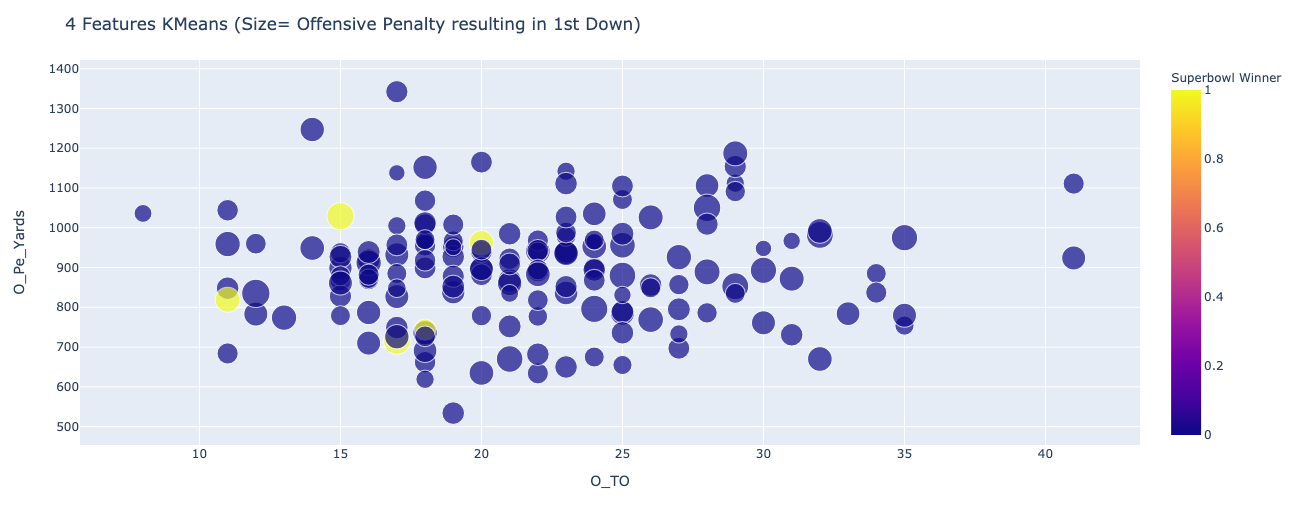

      The last 5 Superbowl winners all had less than 21 Offensive Turnovers
      All but 1 of 5 Superbowl winners allowed for more than 1k Penalty Yards



In [23]:
fig1 = px.scatter(year_5y, x='D_P_Int', y= 'D_Pe_Yards', color="Superbowl Winner",
                 size='D_Pe_1st_D')
fig1.update_layout(title='4 Features KMeans (Size= Defensive Penalty resulting in 1st Down)')
fig1.show()

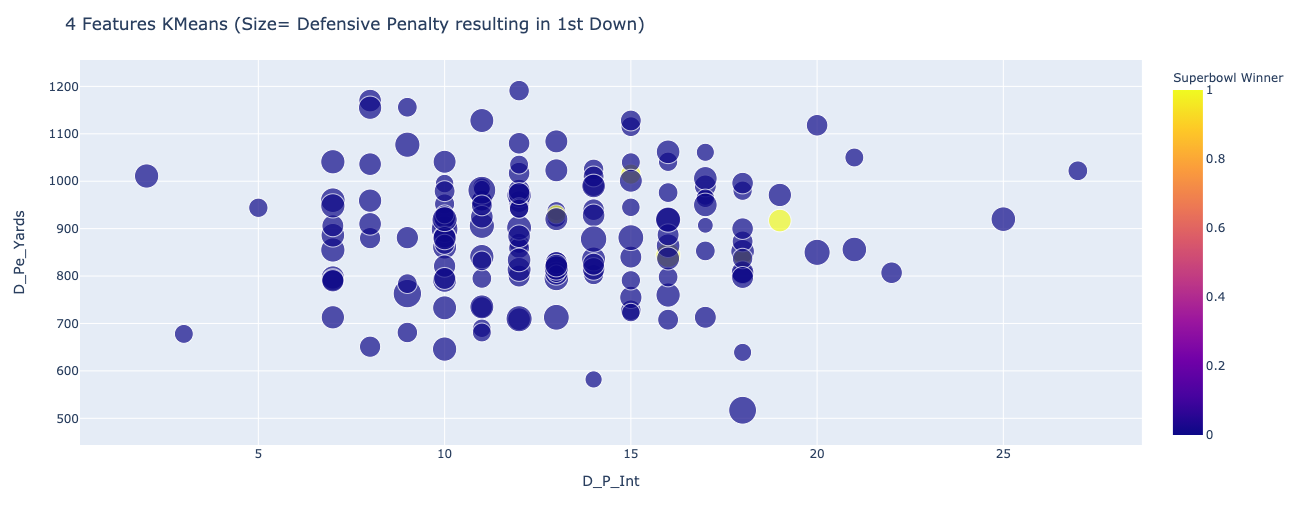

      No correlation to the number of Defensive Pass Interfernce penalties and Superbowl winners
      No correlation to the number of Defensive Penalties and Superbowl winners

#### Missing Data

       No missing or odd data

In [26]:
data.isnull().sum()

O_Rank               0
Team                 0
O_Games_Played       0
O_Points_For         0
O_Total_Yards        0
O_Plays              0
O_Y/Play             0
O_TO                 0
O_Fumbles_Lost       0
O_1st_D              0
O_P_Completions      0
O_P_Attempts         0
O_P_Yards            0
O_P_TD               0
O_P_Int              0
O_P_Y/PA             0
O_P_Passing_1st_D    0
O_R_Att              0
O_R_Yards            0
O_R_TD               0
O_R_Y/A              0
O_R_1st_D            0
O_Pe                 0
O_Pe_Yards           0
O_Pe_1st_D           0
O_Scoring_Drives     0
O_TO_%               0
O_Expected_Points    0
Year                 0
D_Rank               0
D_Games_Played       0
D_Points_Allowed     0
D_Total_Yards        0
D_Plays              0
D_Y/Play             0
D_TD                 0
D_Fumbles_Lost       0
D_1st_D              0
D_P_Completions      0
D_P_Attempts         0
D_P_Yards            0
D_P_TD               0
D_P_Int              0
D_P_Y/PA   

### Modeling

#### Baseline Model 

In [48]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

prediction = statistics.mode(y_train)
y_pred_base = [prediction] * len(y_test)
score = accuracy_score(y_test, y_pred_base)

print(f'Baseline accuracy {round(score * 100, 0)}%')

Baseline accuracy 98.0%


In [ ]:
stati

#### PCA

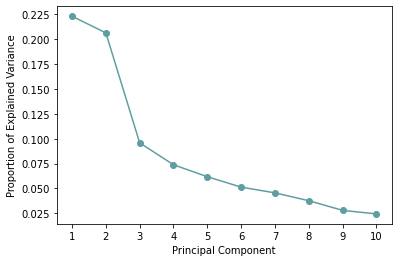

In [27]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
pca = PCA()
pca.fit(scaled_df)

plt.plot(range(1, 11), pca.explained_variance_ratio_[:10], marker= 'o', color= 'cadetblue')
plt.xticks(ticks = range(1, 11))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance');

      Pricipal Component: n_components = 3

#### Predicting Superbowl Winner using KNN

In [52]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
knn_pipe = make_pipeline(StandardScaler(), PCA(n_components= 3), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train) 

print('X Shape: ' + str(X.shape))
print('y Shape: ' + str(y.shape))
print('')
print('Training accuracy:', knn_pipe.score(X_train, y_train))
print('Testing accuracy:', knn_pipe.score(X_test, y_test))

X Shape: (352, 55)
y Shape: (352,)

Training accuracy: 0.9621212121212122
Testing accuracy: 0.9772727272727273


#### Predicting Superbowl Winner using Logistic Regression

In [37]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
logreg_pipe = make_pipeline(StandardScaler(), PCA(n_components= 3), LogisticRegression())
logreg_pipe.fit(X_train, y_train) 

print('X Shape: ' + str(X.shape))
print('y Shape: ' + str(y.shape))
print('')
print('Training accuracy:', logreg_pipe.score(X_train, y_train))
print('Testing accuracy:', logreg_pipe.score(X_test, y_test))

X Shape: (352, 55)
y Shape: (352,)

Training accuracy: 0.9659090909090909
Testing accuracy: 0.9772727272727273


#### Predicting Superbowl Winner using Decision Tree

In [36]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
dtc_pipe = make_pipeline(PCA(n_components= 3), DecisionTreeClassifier(max_depth=3))
dtc_pipe.fit(X_train, y_train) 

print('X Shape: ' + str(X.shape))
print('y Shape: ' + str(y.shape))
print('')
print('Training accuracy:', dtc_pipe.score(X_train, y_train))
print('Testing accuracy:', dtc_pipe.score(X_test, y_test))

X Shape: (352, 55)
y Shape: (352,)

Training accuracy: 0.9772727272727273
Testing accuracy: 0.9772727272727273


##### Hyperparameter Tuning: max_depth 

[0.9772727272727273, 0.9772727272727273, 0.9772727272727273, 0.9772727272727273, 0.9545454545454546, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818]
 


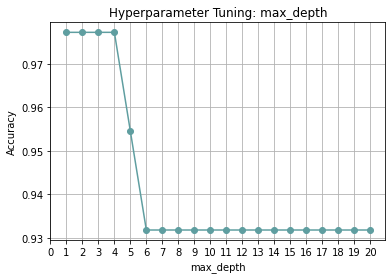

In [35]:
max_depth_range = list(range(1, 21))
accuracy = []
for depth in max_depth_range:
  dtc = DecisionTreeClassifier(max_depth= depth, random_state=3)
  dtc.fit(X_train, y_train)
  score = dtc.score(X_test, y_test)
  accuracy.append(score)
print(accuracy)
print(' ')

plt.plot(max_depth_range, accuracy, color='cadetblue', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning: max_depth')
plt.xticks(range(0,21))
plt.grid(True)
plt.show();

#### Predicting Superbowl Winner using Random Forest

In [39]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
rfc_pipe = make_pipeline(PCA(n_components= 3), RandomForestClassifier(n_estimators=10))
rfc_pipe.fit(X_train, y_train) 

print('X Shape: ' + str(X.shape))
print('y Shape: ' + str(y.shape))
print('')
print('Training accuracy:', rfc_pipe.score(X_train, y_train))
print('Testing accuracy:', rfc_pipe.score(X_test, y_test))

X Shape: (352, 55)
y Shape: (352,)

Training accuracy: 0.9924242424242424
Testing accuracy: 0.9772727272727273


##### Hyperparameter Tuning: n_estimators 

[0.9659090909090909, 0.9772727272727273, 0.9772727272727273]
 


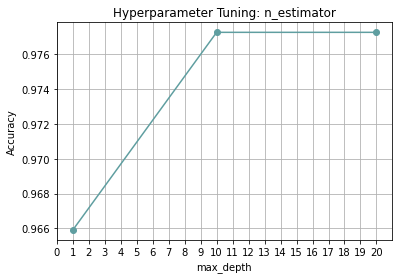

In [40]:
estimator_range = [1] + list(range(10, 21, 10))
scores = []
for estimator in estimator_range:
  rfc = RandomForestClassifier(n_estimators=estimator,
                               random_state=1,
                               bootstrap=True)
  rfc.fit(X_train, y_train)
  scores.append(rfc.score(X_test, y_test))
print(scores)
print(' ')


plt.plot(estimator_range, scores, color='cadetblue', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning: n_estimator')
plt.xticks(range(0,21))
plt.grid(True)
plt.show();

#### Predicting Superbowl Winner using XGBoost

In [41]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
xgb_pipe = make_pipeline(PCA(n_components= 3), XGBClassifier())
xgb_pipe.fit(X_train, y_train) 

print('X Shape: ' + str(X.shape))
print('y Shape: ' + str(y.shape))
print('')
print('Training accuracy:', xgb_pipe.score(X_train, y_train))
print('Testing accuracy:', xgb_pipe.score(X_test, y_test))

X Shape: (352, 55)
y Shape: (352,)

Training accuracy: 0.9886363636363636
Testing accuracy: 0.9772727272727273


[0.9772727272727273, 0.9659090909090909, 0.9772727272727273, 0.9772727272727273]
 


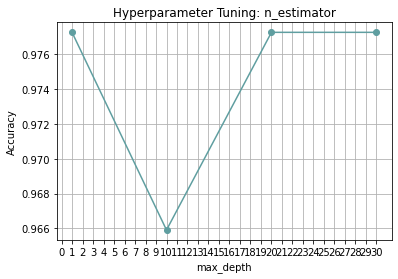

In [76]:
estimator_range = [1] + list(range(10, 31, 10))
scores = []
for estimator in estimator_range:
  xgb = XGBClassifier(n_estimators=estimator,
                               random_state=1,
                               bootstrap=True)
  xgb.fit(X_train, y_train)
  scores.append(xgb.score(X_test, y_test))
print(scores)
print(' ')


plt.plot(estimator_range, scores, color='cadetblue', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning: n_estimator')
plt.xticks(range(0,31))
plt.grid(True)
plt.show();

In [81]:
X = data.drop(columns= ['Superbowl Winner', 'Team'])
y = data['Superbowl Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
xgb_pipe = make_pipeline(PCA(n_components= 3), XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.7, gamma=0.2,
                                           learning_rate=0.15, max_delta_step=0,
                                           max_depth=6, min_child_weight=7,
                                           missing=None, n_estimators=1,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1))
xgb_pipe.fit(X_train, y_train) 

print('X Shape: ' + str(X.shape))
print('y Shape: ' + str(y.shape))
print('')
print('Training accuracy:', xgb_pipe.score(X_train, y_train))
print('Testing accuracy:', xgb_pipe.score(X_test, y_test))

X Shape: (352, 55)
y Shape: (352,)

Training accuracy: 0.9659090909090909
Testing accuracy: 0.9772727272727273


In [55]:
params = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.01, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
}

classifier = xgboost.XGBClassifier()
random_search = RandomizedSearchCV(classifier, 
                                   param_distributions= params, 
                                   n_iter=5, 
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   verbose=3)

In [56]:
random_search.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'gamma': [0.0, 0.01, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                    

In [57]:
random_search.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.2,
 'learning_rate': 0.15,
 'max_depth': 6,
 'min_child_weight': 7,
 'n_estimators': 14}

# Citations

1. https://www.pro-football-reference.com/
2. https://realpython.com/pandas-merge-join-and-concat/